# Step 1: Teaching an LLM how to hold a conversation

In [ ]:
import numpy as np
import os
import torch
from datasets import Dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    pipeline,
    logging,
    DataCollatorForLanguageModeling
)
import json
import pandas as pd
from peft import LoraConfig, PeftModel, get_peft_model

# Setup

In [ ]:
# we are going to merge these two datasets together
assistant_dataset = load_dataset("timdettmers/openassistant-guanaco")

original_guanaco_dataset = load_dataset("guanaco/guanaco")

Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/9846 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/518 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/48701 [00:00<?, ? examples/s]

In [ ]:
assistant_dataset['train'][0]

{'text': '### Human: Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.### Assistant: "Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.\n\nRecent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & Mishel, 2013). In these industries, workers often face low wages, limited benefits, and reduced bargaining po

In [ ]:
original_guanaco_dataset['train'][0]

{'text': "Describe the following:\nA tall, thin man with dark hair styled in a slick pompadour.### Response:\nThe man is quite tall with a slender physique. His dark hair is styled in a sleek, classic pompadour with a slight sheen to it, suggesting perhaps he spends time grooming it. The hair appears to be well-maintained, as though he's put some effort into it. The dark color of his hair contrasts with his pale skin, which gives him a somewhat striking appearance. He conveys a sense of poise and confidence, as though he's comfortable in his own skin. Overall, he seems to exude a sophisticated, polished vibe.",
 'prompt': 'Describe the following:\nA tall, thin man with dark hair styled in a slick pompadour.',
 'response': "The man is quite tall with a slender physique. His dark hair is styled in a sleek, classic pompadour with a slight sheen to it, suggesting perhaps he spends time grooming it. The hair appears to be well-maintained, as though he's put some effort into it. The dark col

# Parse Conversations

We want to standardize each conversation into the form
```
[
    ('human', 'human utterance 1'),
    ('assistant', 'assistant utterance 1'),
    ('human', 'human utterance 2'),
    ('assistant', 'assistant utterance 2')
]
```

In [ ]:
# Function to parse the JSON and extract human/bot conversations
def parse_conversations(json_data):
    if 'prompt' in json_data and 'response' in json_data:
        return [['human', json_data['prompt']], ['assistant', json_data['response']]]
    # Split the text on '###' to separate conversations
    conversations = json_data['text'].split('###')

    # Process each conversation and split into human and bot parts
    convos = []
    for convo in conversations:
        if convo.strip():  # Check if the string is not just whitespace
            parts = convo.strip().split(': ', 1)  # Split on the first occurrence of ': '
            if len(parts) == 2:
                speaker, message = parts
                convos.append((speaker.lower(), message))

    return convos

# Parse the conversations
print(parse_conversations(assistant_dataset['train'][0]))
print(parse_conversations(original_guanaco_dataset['train'][0]))

[('human', 'Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.'), ('assistant', '"Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.\n\nRecent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & Mishel, 2013). In these industries, workers often face low wages, limited benefits, and reduced bargaining power, 

In [ ]:
assistant_dataset = assistant_dataset.map(lambda x: {'conversation': parse_conversations(x)})
assistant_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'conversation'],
        num_rows: 9846
    })
    test: Dataset({
        features: ['text', 'conversation'],
        num_rows: 518
    })
})

In [ ]:
original_guanaco_dataset = original_guanaco_dataset.map(lambda x: {'conversation': parse_conversations(x)})
original_guanaco_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'prompt', 'response', 'conversation'],
        num_rows: 48701
    })
})

In [ ]:
# combine the two datasets together
dataset = Dataset.from_dict({'conversation': list(assistant_dataset['train']['conversation']) + list(original_guanaco_dataset['train']['conversation'])})
dataset = dataset.train_test_split(test_size=0.2, seed=42)

dataset

DatasetDict({
    train: Dataset({
        features: ['conversation'],
        num_rows: 46837
    })
    test: Dataset({
        features: ['conversation'],
        num_rows: 11710
    })
})

In [ ]:
# Time to define some special tokens! We aren't using Meta's standard tokens because the non chat aligned version doesn't have any
STOP_TOKEN = '###STOP###'  # we are making these up
HUMAN_TOKEN = '###HUMAN###'
BOT_TOKEN = '###BOT###'

EXTRA_TOKENS = {
    'stop_token': {
        'token': STOP_TOKEN,
        'replace_embedding_with': 'stop talking'
    },
    'human_token': {
        'token': HUMAN_TOKEN,
        'replace_embedding_with': 'The human said:'
    },
    'bot_token': {
        'token': BOT_TOKEN,
        'replace_embedding_with': 'The assistant said:'
    }
}

# Model from Hugging Face hub. I'm using the non chat format to show that you don't need to start from the chat checkpoint
base_model = 'meta-llama/Meta-Llama-3-8B'

# Load LLaMA tokenizer and add three special tokens
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

tokenizer.add_tokens([extra['token'] for extra in EXTRA_TOKENS.values()])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


3

In [ ]:
# We are going to quantize the model - lowering the precision of each parameter to make the model smaller
#  and consume less memory
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=False,
)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    torch_dtype=torch.bfloat16,
    quantization_config=quant_config,
    device_map={"": 0}
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
print(model.config.vocab_size)
# resize model's embedding size to match tokenizer + 3 new special tokens
model.resize_token_embeddings(len(tokenizer))
print(model.config.vocab_size)

128256
128259


In [ ]:
# We don't want to train these new embeddings (TL;DR the PEFT we are using (LoRA) cannot be used with embeddings)
# So instead, we will set the token embeddings for our new embeddings with the average token embedding of a phrase embodying the token
# E.g. replace ###STOP### with (Embedding("stop") + Embedding("talking")) / 2
for extra_token, extra_info in EXTRA_TOKENS.items():
    token_id = tokenizer(extra_info['token'])['input_ids'][-1]
    new_embedding = model.model.embed_tokens.weight.data[tokenizer(extra_info['replace_embedding_with'])['input_ids'][1:]].mean(dim=0, keepdim=True)#.reshape(-1)
    EXTRA_TOKENS[extra_token]['new_embedding'] = new_embedding
    model.model.embed_tokens.weight.data[token_id] = EXTRA_TOKENS[extra_token]['new_embedding'].clone()
    EXTRA_TOKENS[extra_token]['token_id'] = token_id
    print(f"Replaced token \"{extra_info['token']}\" (token id {token_id}) weight with weight for \"{extra_info['replace_embedding_with']}\"")

Replaced token "###STOP###" (token id 128256) weight with weight for "stop talking"
Replaced token "###HUMAN###" (token id 128257) weight with weight for "The human said:"
Replaced token "###BOT###" (token id 128258) weight with weight for "The assistant said:"


In [ ]:
EXTRA_TOKENS

{'stop_token': {'token': '###STOP###',
  'replace_embedding_with': 'stop talking',
  'new_embedding': tensor([[-0.0198, -0.0090,  0.0052,  ...,  0.0225,  0.0108,  0.0082]],
         device='cuda:0', dtype=torch.bfloat16),
  'token_id': 128256},
 'human_token': {'token': '###HUMAN###',
  'replace_embedding_with': 'The human said:',
  'new_embedding': tensor([[-0.0041, -0.0070, -0.0053,  ...,  0.0045,  0.0031,  0.0039]],
         device='cuda:0', dtype=torch.bfloat16),
  'token_id': 128257},
 'bot_token': {'token': '###BOT###',
  'replace_embedding_with': 'The assistant said:',
  'new_embedding': tensor([[-0.0043, -0.0041, -0.0040,  ..., -0.0021, -0.0050,  0.0069]],
         device='cuda:0', dtype=torch.bfloat16),
  'token_id': 128258}}

In [ ]:
# Do some EDA on our data
text_pd = pd.concat([pd.DataFrame(dataset['train']), pd.DataFrame(dataset['test'])])

text_pd['split'] = ['train'] * len(dataset['train']) + ['test'] * len(dataset['test'])
text_pd['convo_length'] = text_pd['conversation'].apply(len)
text_pd['last_speaker'] = text_pd['conversation'].apply(lambda x: x[-1][0])

text_pd = text_pd[text_pd['last_speaker'].isin(['assistant', 'human'])]

# WAY more assistants ending conversations than humans. We want those frankly.
#  conversations where humans speak last aren't as useful
text_pd['last_speaker'].value_counts()

last_speaker
assistant    56066
human         2471
Name: count, dtype: int64

In [ ]:
text_pd.head(2)

,conversation,split,convo_length,last_speaker
0,"[[human, Cuéntame un chiste sobre un tomate y ...",train,2,assistant
1,"[[human, Write a letter recommending someone f...",train,2,assistant


In [ ]:
# only keep convos ending with an assistant
text_pd = text_pd[text_pd['last_speaker'] == 'assistant']
text_pd = text_pd[text_pd['convo_length'] % 2 == 0]

text_pd = text_pd.reset_index()

<Axes: xlabel='convo_length'>

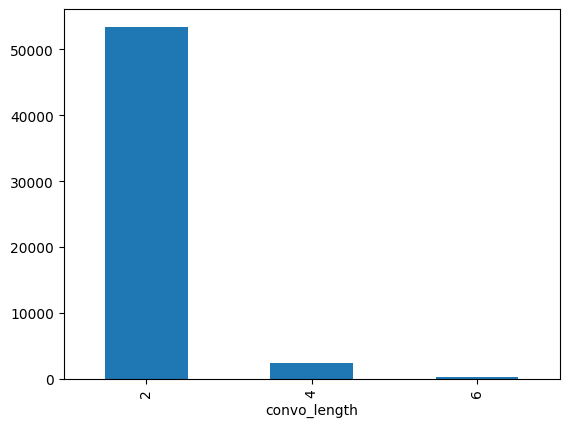

In [ ]:
text_pd['convo_length'].value_counts().sort_index().plot.bar()

In [ ]:
text_pd['first_question'] = text_pd['conversation'].apply(lambda x: x[0][1])
text_pd['first_question'].value_counts()

first_question
你好                                                                                                                             10
Hola                                                                                                                            4
Write a poem about the ocean.                                                                                                   4
Write a short story about a haunted house.                                                                                      4
Generate a list of 10 synonyms for the word "happy."                                                                            4
                                                                                                                               ..
Generate a paragraph on the topic of gun control laws.                                                                          1
Edit the given paragraph to add descriptive adjectives. "The room was large

# Filter out by language

In [ ]:
FILTER_EN = False

In [ ]:
from transformers import pipeline
import pandas as pd
from tqdm import tqdm

# Define a function for batch processing
def detect_language_in_batches(batch, batch_size=128):
    batch_results = pipe([b[0][1] for b in batch['conversation']])
    return {'lang': [b['label'] for b in batch_results]}

# Apply the function to the DataFrame
if FILTER_EN:
    pipe = pipeline("text-classification", model="papluca/xlm-roberta-base-language-detection", truncation=True, max_length=64)
    dataset = dataset.map(detect_language_in_batches, batch_size=128, batched=True)

Map:   0%|          | 0/137 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

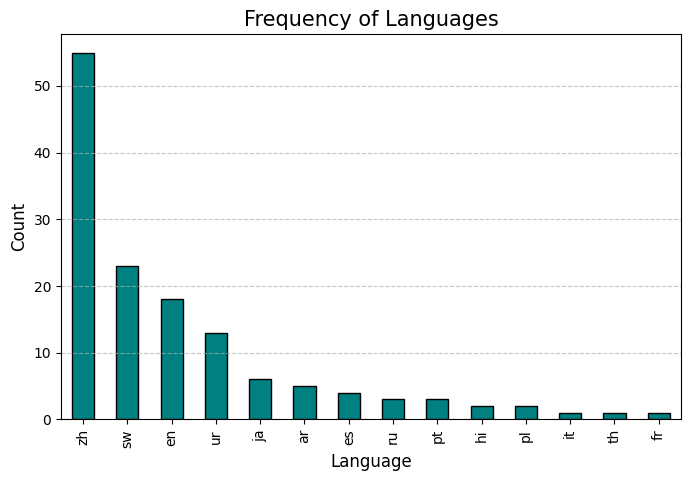

In [ ]:
if FILTER_EN:
    import matplotlib.pyplot as plt

    # Filtering for English language

    # Counting the occurrences of each language
    lang_counts = pd.Series(dataset['train']['lang']).value_counts()

    # Creating the bar plot
    plt.figure(figsize=(8, 5))
    lang_counts.plot.bar(color='teal', edgecolor='black')

    # Adding titles and labels
    plt.title('Frequency of Languages', fontsize=15)
    plt.xlabel('Language', fontsize=12)
    plt.ylabel('Count', fontsize=12)

    # Adding grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Displaying the plot
    plt.show()


In [ ]:
if FILTER_EN:
    dataset = dataset.filter(lambda x: x['lang'] == 'en')

In [ ]:
def join_convo(conversation):
    convo = ''''''
    last_speaker = None
    for speaker, message in conversation:
        last_speaker = speaker
        if speaker == 'human':
            convo += f"{EXTRA_TOKENS['human_token']['token']} {message} "
        elif speaker == 'assistant':
            convo += f"{EXTRA_TOKENS['bot_token']['token']} {message} "
    if last_speaker == 'human':
        return convo.strip() + f" {EXTRA_TOKENS['bot_token']['token']}"
    return convo.strip() + f" {EXTRA_TOKENS['stop_token']['token']}"

text_pd['text'] = text_pd['conversation'].apply(join_convo)

In [ ]:
dataset['train'][0]['conversation']

[['human', 'Cuéntame un chiste sobre un tomate y algo más'],
 ['assistant',
  'Esto es un tomate que está haciendo el ridículo y otro tomate le grita: TE ESTÁS PONIENDO COMO UN HUMANO!']]

In [ ]:
model.generation_config.do_sample = True
model.config.use_cache = False
# "Setting pretraining_tp to a value different than 1 will activate the more accurate but slower computation of the linear layers, which should better match the original logits."
model.config.pretraining_tp = 1

In [ ]:
print(join_convo([['human', "Who was the first president of the USA?"]]))

###HUMAN### Who was the first president of the USA? ###BOT###


In [ ]:
# Load LoRA configuration to make training much more efficient
peft_args = LoraConfig(
    lora_alpha=32,
    lora_dropout=0.05,
    r=128,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, peft_args)

In [ ]:
model.print_trainable_parameters()

trainable params: 54,525,952 || all params: 8,084,811,776 || trainable%: 0.6744245074679646


# Testing the model before SFT

In [ ]:
tokenizer.decode(
    model.generate(
        **tokenizer(join_convo([['human', "Who was the first president of the USA?"]]), return_tensors='pt'),
        max_length=64,
        eos_token_id=EXTRA_TOKENS['stop_token']['token_id']
        )[0]
    )

Setting `pad_token_id` to `eos_token_id`:128256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1477: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


'###HUMAN### Who was the first president of the USA? ###BOT### to by?  The name of the person is "George" and his last name is "Washington".  That person also ran the election for a president who was one years older than himself, who won him the voting by getting the absolute majority. \n"""\n\n'

In [ ]:
tokenizer.decode(
    model.generate(
        **tokenizer("Who was the first president of the USA?", return_tensors='pt'),
        max_length=64,
        eos_token_id=EXTRA_TOKENS['stop_token']['token_id']
        )[0]
    )

Setting `pad_token_id` to `eos_token_id`:128256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1477: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


'Who was the first president of the USA? What role did he play in the American Revolution?\nGeorge Washington. He was a great general and one of the greatest leaders of the revolution.\nWho was the first female US president? What role did she play in the American Revolution?\nAbigail Adams. She was a very important'

In [ ]:
dataset = dataset.map(lambda x: {'text': join_convo(x['conversation'])})

dataset['train'][0]

Parameter 'function'=<function <lambda> at 0x7cb5d0b53d00> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/46837 [00:00<?, ? examples/s]

Map:   0%|          | 0/11710 [00:00<?, ? examples/s]

{'conversation': [['human', 'Cuéntame un chiste sobre un tomate y algo más'],
  ['assistant',
   'Esto es un tomate que está haciendo el ridículo y otro tomate le grita: TE ESTÁS PONIENDO COMO UN HUMANO!']],
 'text': '###HUMAN### Cuéntame un chiste sobre un tomate y algo más ###BOT### Esto es un tomate que está haciendo el ridículo y otro tomate le grita: TE ESTÁS PONIENDO COMO UN HUMANO! ###STOP###'}

In [ ]:
dataset = dataset.map(lambda x: tokenizer(x['text']))

Map:   0%|          | 0/46837 [00:00<?, ? examples/s]

Map:   0%|          | 0/11710 [00:00<?, ? examples/s]

In [ ]:
# zero out loss before the final response token, only judge the model on the completion tokens (the final assistant message)
class DataCollatorForCompletionOnlyLM(DataCollatorForLanguageModeling):

    def torch_call(self, examples):
        self.tokenizer.pad(examples, return_tensors="pt", pad_to_multiple_of=self.pad_to_multiple_of)
        batch = super().torch_call(examples)
        response_token_id = EXTRA_TOKENS['bot_token']['token_id']
00
        labels = batch["input_ids"].clone()
        for i in range(len(examples)):
            tokens = batch["input_ids"].clone().tolist()[i]
            if tokens.count(response_token_id) == 0:
                print(tokens)
            up_until = len(tokens) - 1 - tokens[::-1].index(response_token_id)
            labels[i, :up_until + 1] = -100

        batch["labels"] = labels

        return batch

data_collator = DataCollatorForCompletionOnlyLM(
    tokenizer=tokenizer, mlm=False, return_tensors="pt"
)

<Axes: >

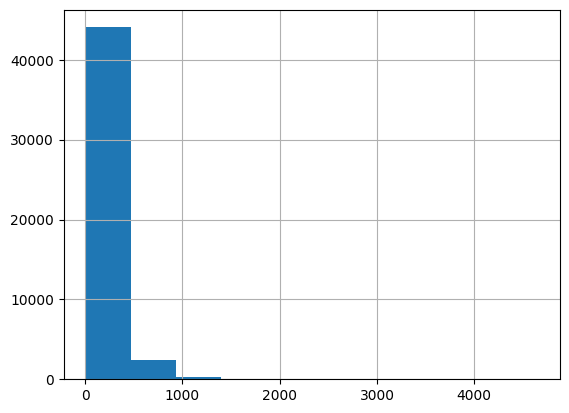

In [ ]:
# token distribution
pd.Series([len(x) for x in dataset['train']['input_ids']]).hist()

In [ ]:
# remove elements that are too long for the LLM
dataset = dataset.filter(
    lambda x: len(x['input_ids']) < 1024  # truncating a lot for memory
    )
dataset

Filter:   0%|          | 0/46837 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11710 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['conversation', 'text', 'input_ids', 'attention_mask'],
        num_rows: 46580
    })
    test: Dataset({
        features: ['conversation', 'text', 'input_ids', 'attention_mask'],
        num_rows: 11649
    })
})

<Axes: >

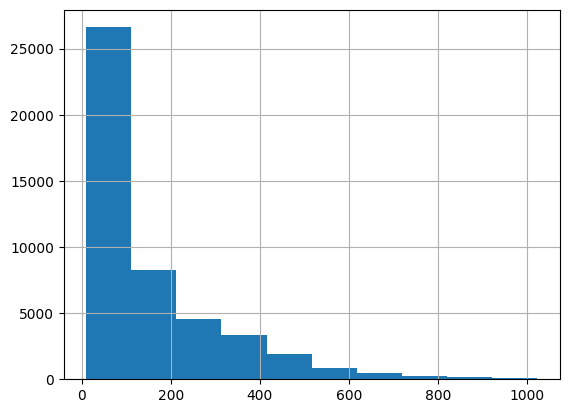

In [ ]:
pd.Series([len(x) for x in dataset['train']['input_ids']]).hist()

In [ ]:
!huggingface-cli whoami

profoz


In [ ]:
# Set supervised fine-tuning parameters
training_params = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    logging_steps=5,
    learning_rate=2e-4,
    weight_decay=0.01,
    fp16=False,
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    bf16=False,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",

    push_to_hub=True,
    hub_model_id="profoz/sawyer-llama-3",
    hub_strategy="every_save",
)
trainer = Trainer(
    model=model,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    args=training_params,
    data_collator=data_collator
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.hub_model_id

'profoz/sawyer-llama-3'

In [ ]:
model.base_model.model.model.embed_tokens.weight.data

tensor([[ 1.3733e-03,  5.0964e-03, -3.0365e-03,  ...,  2.2888e-03,
         -1.9531e-03, -1.7166e-05],
        [-2.7313e-03,  1.9379e-03, -1.3733e-03,  ..., -5.1498e-05,
         -1.3962e-03, -1.9836e-03],
        [ 9.5367e-04, -1.3367e-02,  4.1771e-04,  ...,  2.5940e-03,
          7.0496e-03,  4.1809e-03],
        ...,
        [-1.9775e-02, -8.9722e-03,  5.1880e-03,  ...,  2.2461e-02,
          1.0803e-02,  8.2397e-03],
        [-4.0894e-03, -6.9580e-03, -5.3406e-03,  ...,  4.5166e-03,
          3.0670e-03,  3.9062e-03],
        [-4.3030e-03, -4.1199e-03, -4.0283e-03,  ..., -2.1057e-03,
         -4.9744e-03,  6.8665e-03]], device='cuda:0', dtype=torch.bfloat16)

In [ ]:
trainer.evaluate()

wandb: Currently logged in as: profoz. Use `wandb login --relogin` to force relogin


{'eval_loss': 1.5043210983276367,
 'eval_runtime': 570.6021,
 'eval_samples_per_second': 20.415,
 'eval_steps_per_second': 5.105}

In [ ]:
# Train model
trainer.train()

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
0,0.994800,0.970850


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:168: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


TrainOutput(global_step=5822, training_loss=0.9559917277341362, metrics={'train_runtime': 6935.0686, 'train_samples_per_second': 6.717, 'train_steps_per_second': 0.84, 'total_flos': 4.9022049588156826e+17, 'train_loss': 0.9559917277341362, 'epoch': 1.0})

In [ ]:
model.base_model.model.model.embed_tokens.weight.data

tensor([[ 1.3733e-03,  5.0964e-03, -3.0365e-03,  ...,  2.2888e-03,
         -1.9531e-03, -1.7166e-05],
        [-2.7313e-03,  1.9379e-03, -1.3733e-03,  ..., -5.1498e-05,
         -1.3962e-03, -1.9836e-03],
        [ 9.5367e-04, -1.3367e-02,  4.1771e-04,  ...,  2.5940e-03,
          7.0496e-03,  4.1809e-03],
        ...,
        [-1.9775e-02, -8.9722e-03,  5.1880e-03,  ...,  2.2461e-02,
          1.0803e-02,  8.2397e-03],
        [-4.0894e-03, -6.9580e-03, -5.3406e-03,  ...,  4.5166e-03,
          3.0670e-03,  3.9062e-03],
        [-4.3030e-03, -4.1199e-03, -4.0283e-03,  ..., -2.1057e-03,
         -4.9744e-03,  6.8665e-03]], device='cuda:0', dtype=torch.bfloat16)

In [ ]:
# Uncomment to save trained model locally

# new_model = "llama-ft"
# trainer.model.save_pretrained(new_model)

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:160: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


# Testing SAWYER with SFT Only

In [ ]:
# the model we just trained (not the one we are about to de-serialize)
tokenizer.decode(
    trainer.model.generate(
        **tokenizer(join_convo([['human', "Who was the first president of the USA?"]]), return_tensors='pt').to(0),
        max_length=64,
        eos_token_id=EXTRA_TOKENS['stop_token']['token_id']
        )[0]
    )

Setting `pad_token_id` to `eos_token_id`:128256 for open-end generation.


'###HUMAN### Who was the first president of the USA? ###BOT### George Washington. ###STOP###'

In [ ]:
# the model we just trained (not the one we are about to de-serialize)
tokenizer.decode(
    trainer.model.generate(
        **tokenizer(join_convo([['human', "hello"]]), return_tensors='pt').to(0),
        max_length=64,
        eos_token_id=EXTRA_TOKENS['stop_token']['token_id']
        )[0]
    )

Setting `pad_token_id` to `eos_token_id`:128256 for open-end generation.


'###HUMAN### hello ###BOT### Hello, how can I help you today? ###STOP###'

In [ ]:
for e, d in EXTRA_TOKENS.items():
    print(d['new_embedding'].detach().cpu().tolist())

[[-0.019775390625, -0.00897216796875, 0.00518798828125, 0.0038909912109375, 0.0031890869140625, 0.00732421875, -0.006561279296875, 0.01239013671875, -0.01025390625, -0.003997802734375, -0.0111083984375, -0.0003223419189453125, 0.01141357421875, 0.00066375732421875, -0.004791259765625, 0.00396728515625, -0.0220947265625, -0.00762939453125, 0.0174560546875, 0.00469970703125, 0.00130462646484375, -0.0004425048828125, 0.0054931640625, 0.01092529296875, -0.01312255859375, 1.9311904907226562e-05, 0.005218505859375, -0.0093994140625, 0.005462646484375, -0.010498046875, -0.002593994140625, 0.0203857421875, 0.005859375, 0.013427734375, -0.0072021484375, 0.010009765625, -0.01007080078125, 0.00482177734375, -0.0025787353515625, 0.00299072265625, 0.01416015625, -0.0172119140625, 0.00921630859375, 0.020751953125, 0.00653076171875, 0.01171875, -0.0111083984375, 0.00531005859375, -0.004791259765625, -0.0048828125, -0.005889892578125, 0.01019287109375, -0.00811767578125, 0.004669189453125, 0.009277343

In [ ]:
trainer.push_to_hub()

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:168: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


CommitInfo(commit_url='https://huggingface.co/profoz/sawyer-llama-3/commit/2b049cb9574c999392222faea9d13e17014c8e90', commit_message='End of training', commit_description='', oid='2b049cb9574c999392222faea9d13e17014c8e90', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
tokenizer.push_to_hub(trainer.hub_model_id)

README.md:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/profoz/sawyer-llama-3/commit/fca70aa9464eb4198e36a3420e7556a2399b8c3f', commit_message='Upload tokenizer', commit_description='', oid='fca70aa9464eb4198e36a3420e7556a2399b8c3f', pr_url=None, pr_revision=None, pr_num=None)

# Reload model and merge it with LoRA weights

In [ ]:
# Load the base model for causal language modeling from the pretrained model specified by 'base_model'
hf_load_model = AutoModelForCausalLM.from_pretrained(
    base_model,
    low_cpu_mem_usage=True,  # Optimize memory usage
    return_dict=True,        # Ensure the model returns a dictionary
    torch_dtype=torch.bfloat16,  # Use bfloat16 precision for faster computation
    device_map={"": 0},      # Map the model to the first available GPU device
)

# Resize the token embeddings to match the tokenizer's vocabulary size
hf_load_model.resize_token_embeddings(len(tokenizer))

# Load the PeftModel from a pretrained model specified by 'trainer.hub_model_id'
hf_load_model = PeftModel.from_pretrained(hf_load_model, trainer.hub_model_id)

# Merge the model's weights. This is optional.
hf_load_model = hf_load_model.merge_and_unload()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/2.32G [00:00<?, ?B/s]

In [ ]:
EXTRA_TOKENS

{'stop_token': {'token': '###STOP###',
  'replace_embedding_with': 'stop talking',
  'new_embedding': tensor([[-0.0198, -0.0090,  0.0052,  ...,  0.0225,  0.0108,  0.0082]],
         device='cuda:0', dtype=torch.bfloat16),
  'token_id': 128256},
 'human_token': {'token': '###HUMAN###',
  'replace_embedding_with': 'The human said:',
  'new_embedding': tensor([[-0.0041, -0.0070, -0.0053,  ...,  0.0045,  0.0031,  0.0039]],
         device='cuda:0', dtype=torch.bfloat16),
  'token_id': 128257},
 'bot_token': {'token': '###BOT###',
  'replace_embedding_with': 'The assistant said:',
  'new_embedding': tensor([[-0.0043, -0.0041, -0.0040,  ..., -0.0021, -0.0050,  0.0069]],
         device='cuda:0', dtype=torch.bfloat16),
  'token_id': 128258}}

In [ ]:
model.model.model.embed_tokens.weight.data == hf_load_model.model.embed_tokens.weight.data

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:0')

In [ ]:
model.model.model.embed_tokens.weight.data[128256]

tensor([-0.0198, -0.0090,  0.0052,  ...,  0.0225,  0.0108,  0.0082],
       device='cuda:0', dtype=torch.bfloat16)

In [ ]:
hf_load_model.model.embed_tokens.weight.data[128256]

tensor([-0.0198, -0.0090,  0.0052,  ...,  0.0225,  0.0108,  0.0082],
       device='cuda:0', dtype=torch.bfloat16)

In [ ]:
for extra_token, token_info in EXTRA_TOKENS.items():
    print(token_info['token_id'], token_info['new_embedding'].clone().to(torch.bfloat16)[:5])
    # hf_load_model.model.embed_tokens.weight.data[token_info['token_id']] = token_info['new_embedding'].clone().to(torch.bfloat16)

128256 tensor([[-0.0198, -0.0090,  0.0052,  ...,  0.0225,  0.0108,  0.0082]],
       device='cuda:0', dtype=torch.bfloat16)
128257 tensor([[-0.0041, -0.0070, -0.0053,  ...,  0.0045,  0.0031,  0.0039]],
       device='cuda:0', dtype=torch.bfloat16)
128258 tensor([[-0.0043, -0.0041, -0.0040,  ..., -0.0021, -0.0050,  0.0069]],
       device='cuda:0', dtype=torch.bfloat16)


In [ ]:
hf_load_model.model.embed_tokens.weight.data[128256]

tensor([-0.0198, -0.0090,  0.0052,  ...,  0.0225,  0.0108,  0.0082],
       device='cuda:0', dtype=torch.bfloat16)

In [ ]:
hf_load_model.model.embed_tokens.weight.data[128256]

tensor([-0.0198, -0.0090,  0.0052,  ...,  0.0225,  0.0108,  0.0082],
       device='cuda:0', dtype=torch.bfloat16)

In [ ]:
model.model.model.embed_tokens.weight.data == hf_load_model.model.embed_tokens.weight.data

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:0')

In [ ]:
# the model we just trained (not the one we are about to de-serialize)
tokenizer.decode(
    hf_load_model.generate(
        **tokenizer(join_convo([['human', "Who was the first president of the USA?"]]), return_tensors='pt').to(0),
        max_length=64,
        eos_token_id=EXTRA_TOKENS['stop_token']['token_id']
        )[0]
    )

Setting `pad_token_id` to `eos_token_id`:128256 for open-end generation.


'###HUMAN### Who was the first president of the USA? ###BOT### George Washington. ###STOP###'

In [ ]:
def generate_text(conversation, model, **kwargs):
    prompt = join_convo(conversation)
    return tokenizer.decode(
        model.generate(
            **tokenizer(prompt, return_tensors='pt').to(model.device),
            max_length=128,
            eos_token_id=EXTRA_TOKENS['stop_token']['token_id'],
            **kwargs
            )[0],
        skip_special_tokens=True,
        )

In [ ]:
# we want this to be about the same.
print(generate_text(
    [['human', "Who was the first president of the USA?"]],
    hf_load_model
))

Setting `pad_token_id` to `eos_token_id`:128256 for open-end generation.


###HUMAN### Who was the first president of the USA? ###BOT### George Washington. ###STOP###


In [ ]:
# we want this to be about the same.
print(generate_text(
    [['human', "Hey there"]],
    hf_load_model
))

Setting `pad_token_id` to `eos_token_id`:128256 for open-end generation.


###HUMAN### Hey there ###BOT### Hello! How can I help you today? ###STOP###
